In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard


from einops import rearrange

from typing import Optional, List

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)


Seed set to 42


Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [2]:

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "D:/Malky/research/data/mla_jax"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "D:/Malky/research/saved_models/VisionTransformer"

Seed set to 42
Seed set to 42


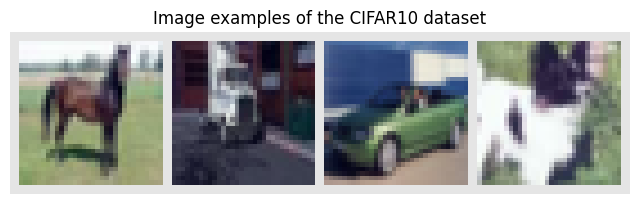

In [3]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=10, shuffle=True, drop_last=True, pin_memory=True, num_workers=1)
val_loader = data.DataLoader(val_set, batch_size=10, shuffle=False, drop_last=False, num_workers=1)
test_loader = data.DataLoader(test_set, batch_size=10, shuffle=False, drop_last=False, num_workers=1)

# Visualize some examples
NUM_IMAGES = 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [4]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

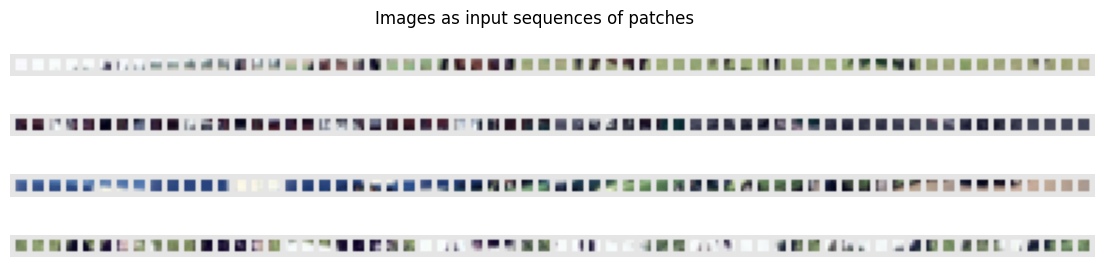

In [5]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [6]:
for i in enumerate(train_loader):
    idx, data = i
    print(len(i))
    for j in data:
        print(j[0].size())
        break
    break

2
torch.Size([3, 32, 32])


In [ ]:
def rotary_embedding(x, max_seq_len, dim):
    """Apply RoPE to input tensor x."""
    # Ensure max_seq_len is a concrete value, not symbolic
    positions = torch.arange(max_seq_len, dtype=torch.float32)
    
    # Compute frequency values
    freqs = 1.0 / (10000 ** (torch.arange(0, dim, 2, dtype=torch.float32) / dim))

    # Compute angles
    angles = positions[:, None] * freqs[None, :]

    # Compute sin and cos
    sin, cos = torch.sin(angles), torch.cos(angles)

    # Apply rotary embeddings to the input tensor x
    x1, x2 = x[..., ::2], x[..., 1::2]
    x_rotated = torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

    return x_rotated

def scaled_dot_product(q, k, v, mask=None):
    """Computes the scaled dot-product attention in PyTorch."""
    # q -> [B, n_h, L, d_h + d_h^R] 
    # k -> [B, n_h, L, d_h + d_h^R] 
    scale = torch.sqrt(torch.tensor(q.shape[-1], dtype=torch.float32))  # Scaling factor

    scores = torch.einsum("bhqd,bhkd->bhqk", q, k) / scale  # Efficient batch matmul
    
    if mask is not None:
        scores += mask  # Apply mask in-place

    attention = F.softmax(scores, dim=-1)  # Compute attention weights
    values = torch.einsum("bhqk,bhkd->bhqd", attention, v)  # Apply attention to values

    return values, attention


def expand_mask(mask):
    """Expands a mask tensor to shape (B, num_heads, L, L) in PyTorch."""
    ndim = mask.dim()  # PyTorch equivalent of `mask.ndim`
    assert ndim >= 2, "Mask must be at least 2D (L x L)"

    if ndim == 2:  # (L, L) → (1, 1, L, L)
        return mask.unsqueeze(0).unsqueeze(0)  
    elif ndim == 3:  # (B, L, L) → (B, 1, L, L)
        return mask.unsqueeze(1)  
    
    return mask  # If already (B, num_heads, L, L), return as is


class MultiHeadLatentAttentionRope(nn.Module):
    def __init__(self, d_model, n_h, d_c, d_c_, d_h_R):
        super().__init__()
        self.d_model = d_model  # Output dimension
        self.n_h = n_h  # Number of heads
        self.d_c = d_c  # Latent compression dimension for KV
        self.d_c_ = d_c_  # Latent compression dimension for Queries
        self.d_h_R = d_h_R  # Rotated dimension for RoPE

        # Input projection
        self.input_h = nn.Linear(in_features = 65,  out_features= self.d_model)

        # KV down-projection
        self.kv_proj = nn.Linear(in_features =self.d_model ,out_features = 2 * self.d_c)

        # Up-projection for KV
        self.ukv_proj = nn.Linear(in_features = 2 * self.d_c, out_features = 2 * self.d_model)

        # Down-projection for Queries
        self.q_proj = nn.Linear(in_features =self.d_model ,out_features = self.d_c_ + self.d_h_R * self.n_h)

        # Up-projection for Queries
        self.uq_proj = nn.Linear(in_features=self.d_c_ + self.d_h_R * self.n_h, out_features= self.d_model)

        # Rotated projection for keys (shared)
        self.kr_proj = nn.Linear(self.d_model, self.d_h_R)

        # Output projection
        self.o_proj = nn.Linear(self.d_model, self.d_model)

        # Layer Normalization instead of RMSNorm
        self.norm_v = nn.LayerNorm(self.d_model)
        self.norm_k = nn.LayerNorm(self.d_model)
        self.norm_q = nn.LayerNorm(self.d_model)

    def forward(self, x, mask=None):
        B, L, D = x.shape  # Batch size, Sequence length, Embedding dim

        print("ROPE", x.shape)

        if D != self.d_model:
            x = self.input_h(x)
            print("ROPE 1 ", x.shape)

        if mask is not None:
            mask = expand_mask(mask)

        print("ROPE 2", x.shape)

        # Down-project and up-project KV
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = torch.chunk(self.ukv_proj(c_kv), 2, dim=-1)  # [B, L, d_model] each

        # Down-project queries
        c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
        q_c, q_r = torch.split(c_q, [self.d_c_, self.d_h_R], dim=-1)  # [B, L, d_c_], [B, L, d_h_R]

        # Up-project compressed queries
        q_c = self.uq_proj(q_c)  # [B, L, d_model]

        # Apply RoPE (replace `rotary_embedding` with your PyTorch version)
        q_r = rotary_embedding(q_r, L, self.d_h_R * self.n_h)  # [batch_size, seq_len, d_h_R]
        k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [batch_size, seq_len, d_h_R]

        # Expand and reshape k_r
        k_r = k_r.unsqueeze(2)  # [B, L, 1, d_h_R]
        k_r = k_r.expand(-1, -1, self.n_h, -1)  # [B, L, n_h, d_h_R]
        k_r = rearrange(k_r, "b l h d -> b h l d")

        # Normalize v, k, and q_c
        v = self.norm_v(v)
        k = self.norm_k(k)
        q_c = self.norm_q(q_c)

        # Reshape heads
        q_c, k, v, q_r = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v, q_r])

        # Concatenate query and key rotated parts
        q = torch.cat([q_c, q_r], dim=-1)  # [B, n_h, L, d_h + d_h^R]
        k = torch.cat([k, k_r], dim=-1)  # [B, n_h, L, d_h + d_h^R]

        # Compute attention (replace `scaled_dot_product` with your PyTorch version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and project output
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention
    

class MultiHeadLatentAttention(nn.Module):
    def __init__(self, d_model, n_h, d_c, d_c_):
        super().__init__()
        self.d_model = d_model  # Output dimension
        self.n_h = n_h  # Number of heads
        self.d_c = d_c  # Latent compression dimension
        self.d_c_ = d_c_  # Latent compression dimension for Q

        # Layer normalization instead of RMSNorm
        self.norm_v = nn.LayerNorm(self.d_model)
        self.norm_k = nn.LayerNorm(self.d_model)
        self.norm_q = nn.LayerNorm(self.d_model)

        # Fused projection layers for efficiency
        self.kv_proj = nn.Linear(self.d_model, 2 * self.d_c)
        self.q_proj = nn.Linear(self.d_model, self.d_c_)

        # Up-projection for keys, values, and queries
        self.ukv_proj = nn.Linear(2 * self.d_c, 2 * self.d_model)
        self.uq_proj = nn.Linear(self.d_c_, self.d_model)

        # Output projection
        self.o_proj = nn.Linear(self.d_model, self.d_model)

    def forward(self, x, mask=None):
     
        if mask is not None:
            mask = expand_mask(mask)

        # Compute compressed KV projection
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = torch.chunk(self.ukv_proj(c_kv), 2, dim=-1)  # [B, L, d_model] each

        # Compute query projection
        q = self.uq_proj(self.q_proj(x))  # [B, L, d_model]

        # Reshape heads using einops
        q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

        # Apply normalization
        q = self.norm_q(q)
        k = self.norm_k(k)
        v = self.norm_v(v)

        # Compute attention (replace `scaled_dot_product` with its PyTorch version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and output projection
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention
    
class TransformerBlock(nn.Module):
    """A Transformer block with LayerNorm and residual connections."""
    def __init__(self, d_model, n_h, dim_feedforward, dropout_rate=0.1, 
                 d_c=64, d_c_=64, d_h_R=32, position=False):
        super().__init__()

        self.d_model = d_model
        self.n_h = n_h
        self.dim_feedforward = dim_feedforward
        self.dropout_rate = dropout_rate
        self.d_c = d_c
        self.d_c_ = d_c_
        self.d_h_R = d_h_R
        self.position = position

        # Attention layer (with or without rotary embeddings)
        if self.position:
            self.self_attn = MultiHeadLatentAttentionRope(
                d_model=self.d_model, n_h=self.n_h, d_c=self.d_c, d_c_=self.d_c_, d_h_R=self.d_h_R
            )
        else:
            self.self_attn = MultiHeadLatentAttention(
                d_model=self.d_model, n_h=self.n_h, d_c=self.d_c, d_c_=self.d_c_
            )

        # Feed-Forward Network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(self.d_model, self.dim_feedforward),
            nn.GELU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.dim_feedforward, self.d_model),
            nn.Dropout(self.dropout_rate),
        )

        # Layer Normalization (Replaces RMSNorm from JAX/Flax)
        self.norm1 = nn.LayerNorm(self.d_model)
        self.norm2 = nn.LayerNorm(self.d_model)

        # Dropout layer
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, x, mask=None):
        """
        Args:
            x: Input tensor of shape (batch, length, d_model)
            mask: Attention mask of shape (batch, heads, length, length) or None
        Returns:
            Output tensor of shape (batch, length, d_model)
        """

        print("fdsfsdf", x.shape)
        # First LayerNorm + Residual Connection
        residual = x
        x, _ = self.self_attn(x, mask=mask)
        x = self.dropout(x)
        x = x + residual  # Residual connection

        # Second LayerNorm + Residual Connection
        x = self.norm2(x)
        x = self.dropout(x)

        residual = x
        x = self.ffn(x)
        x = x + residual  # Residual connection

        return x
    

class VisionTransformer(nn.Module):
    """Vision Transformer with optional Latent Space and RoPE."""

    def __init__(self, embed_dim, hidden_dim, num_heads, num_channels, num_layers, 
                 num_classes, patch_size, num_patches, dropout_prob=0.0, 
                 position=True, d_c=64, d_c_=64, d_h_R=64):
        super().__init__()

        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.num_channels = num_channels
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.dropout_prob = dropout_prob
        self.position = position
        self.d_c = d_c
        self.d_c_ = d_c_
        self.d_h_R = d_h_R

        # Input embedding layer
        self.input_layer = nn.Linear(in_features=48, out_features = self.embed_dim)

        # Transformer layers
        self.transformer = nn.ModuleList([
            TransformerBlock(
                d_model=self.embed_dim, 
                dim_feedforward=self.hidden_dim, 
                n_h=self.num_heads, 
                dropout_rate=self.dropout_prob, 
                d_c=self.d_c, 
                d_c_=self.d_c_, 
                d_h_R=self.d_h_R, 
                position=self.position
            ) for _ in range(self.num_layers)
        ])

        # MLP head for classification
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.embed_dim),
            nn.Linear(self.embed_dim, self.num_classes)
        )

        self.dropout = nn.Dropout(self.dropout_prob)

        # Learnable class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.embed_dim))

    
    def forward(self, x, train=True):
        """
        Forward pass for ViT.
        Args:
            x: Input image tensor [B, C, H, W]
            train: Boolean flag for dropout behavior
        Returns:
            out: Logits for classification
        """
        # Convert image to patch embeddings
        x = img_to_patch(x, self.patch_size)  # Shape: [B, T, embed_dim]
        B, T, _ = x.shape

        print(x.shape)

        # Apply input embedding
        x = self.input_layer(x)
        print("MIERDA", x.shape)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.expand(B, -1, -1)  # Expand along batch dimension
        x = torch.cat([cls_token, x], dim=1)  # Shape: [B, T+1, embed_dim]
        

        # Apply Transformer blocks
        x = self.dropout(x) if train else x
        for attn_block in self.transformer:
            x = attn_block(x)

        # Classification head
        cls_token_out = x[:, 0]  # CLS token output
        out = self.mlp_head(cls_token_out)

        return out

    def get_attention_maps(self, x, mask=None, train=True):
        """
        Extracts attention matrices from the entire Transformer for a batch.
        """
        x = img_to_patch(x, self.patch_size)  # Convert to patches
        B, T, _ = x.shape
        x = self.input_layer(x)  # Apply embedding

        # Get attention maps from Transformer encoder
        attention_maps = [attn_block.self_attn(x, mask=mask)[1] for attn_block in self.transformer]
        
        return attention_maps
    


In [14]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [15]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ViT"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [16]:
d_model = 256
hidden_dim = d_model * 2
n_h = 2
d_h = d_model//n_h
d_c = d_h // 2
d_c_ = d_h // 4
d_h_R= d_h // 4
num_layers = 2

model, results = train_model(model_kwargs={
    'embed_dim': d_model,
    'hidden_dim': hidden_dim,
    'num_heads': n_h,
    'num_layers': num_layers,
    'patch_size': 4,
    'num_channels': 3,
    'num_patches': 64,
    'num_classes': 10,
    'dropout_prob': 0.2,
    'd_c' : d_c,
    'd_c_': d_c_,
    'd_h_R' : d_h_R,
    'position': True
    },
    lr=3e-4)
print("ViT results", results)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


torch.Size([10, 64, 48])
MIERDA torch.Size([10, 64, 256])
fdsfsdf torch.Size([10, 65, 256])
ROPE torch.Size([10, 65, 256])
ROPE 2 torch.Size([10, 65, 256])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (650x256 and 128x512)